In [1]:
import os
import json
from model_functions import PaddedDataset, trainer_gpt2_transformer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import GPT2Config, GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling, TrainingArguments, Trainer


PATH_VOCAB = "../0_data/5_vocabs"
PATH_WORD_DATA = "../0_data/6_word_data"
PATH_MODELS = "../0_data/7_models"
PATH_MODELS_LOSS = "../0_data/7_models/loss"
PATH_MODELS_CONFIG = "../0_data/7_models/config"

for path in [PATH_MODELS, PATH_MODELS_LOSS, PATH_MODELS_CONFIG]:
    if not os.path.exists(path):
        os.makedirs(path)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
model_df = pd.read_excel(f"{PATH_MODELS}/comparison_model_stats.xlsx", index_col="Unnamed: 0")
model_df

,name,max_length,emb_dim,attention_heads,layers,dropout,learning_rate,epochs,batch_size,ran,runtime,runtime_min,min_loss,at_epoch,perplexity,incorrect_notes,correct_notes,correct_rate
0,a1_50,1024,256,4,6,0,0.001,50,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a2_50,1024,256,4,6,0,0.001,50,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a3_50,1024,256,4,6,0,0.001,50,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b_50,1024,256,4,6,0,0.001,50,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c_50,1024,256,4,6,0,0.001,50,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,d_50,1024,256,4,6,0,0.001,50,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,a1,1024,256,4,6,0,0.001,20,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,a2,1024,256,4,6,0,0.001,20,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,a3,1024,256,4,6,0,0.001,20,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,b,1024,256,4,6,0,0.001,20,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.931300,2.449908
2,2.345700,2.279532
3,2.227800,2.224419
4,2.194600,2.209340
5,2.165400,2.162284
6,2.095400,2.060539
7,1.932700,1.781883
8,1.710700,1.607023
9,1.618000,1.560877
10,1.569400,1.519859


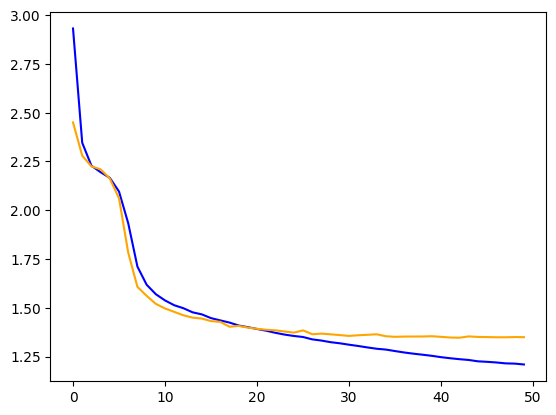

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.431900,2.039774
2,1.951300,1.945047
3,1.893600,1.909030
4,1.862200,1.886701
5,1.841500,1.867258
6,1.822700,1.862051
7,1.801500,1.848624
8,1.781100,1.836507
9,1.749900,1.734678
10,1.560300,1.450931


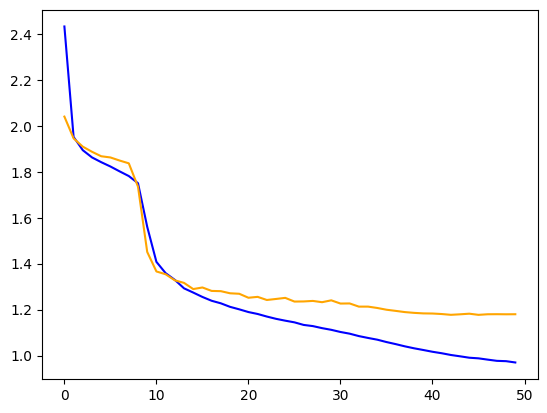

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.585700,2.184849
2,2.148300,2.150070
3,2.094200,2.110110
4,2.061600,2.086567
5,2.029600,2.029573
6,1.932200,1.774811
7,1.668200,1.571860
8,1.565800,1.529014
9,1.533800,1.497328
10,1.507300,1.494196


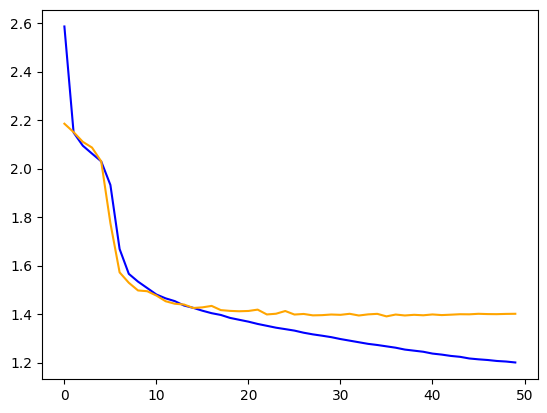

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.502500,2.160710
2,2.116100,2.102527
3,2.067800,2.075110
4,2.032600,2.046416
5,2.003500,2.017008
6,1.969900,1.962951
7,1.783700,1.589918
8,1.540100,1.489721
9,1.466200,1.465571
10,1.429700,1.435958


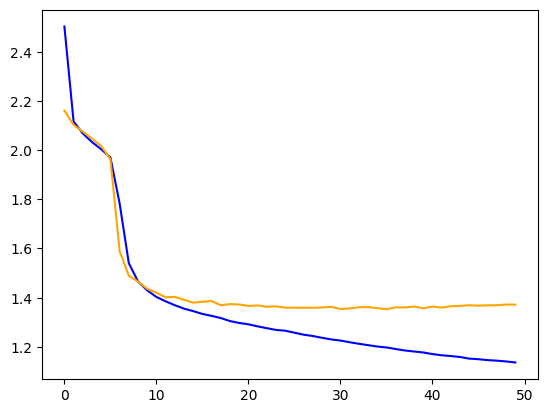

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.486100,2.234648
2,2.180000,2.150926
3,2.107200,2.107867
4,2.070000,2.104307
5,2.040000,2.064749
6,2.014600,2.031489
7,1.898000,1.735131
8,1.627400,1.535051
9,1.538900,1.492306
10,1.504500,1.464982


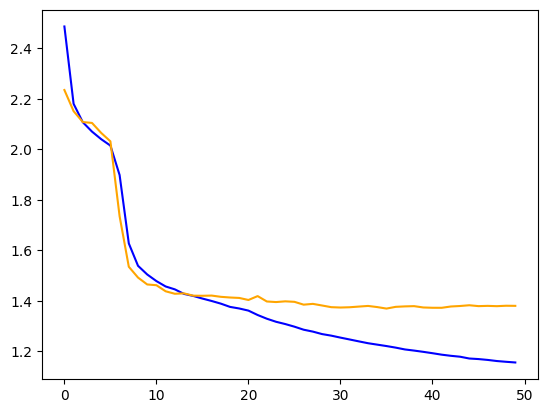

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.192900,1.968058
2,1.876500,1.875040
3,1.823100,1.854711
4,1.801400,1.834250
5,1.778500,1.813654
6,1.762500,1.809055
7,1.738900,1.774902
8,1.648700,1.483994
9,1.406700,1.343840
10,1.337900,1.300618


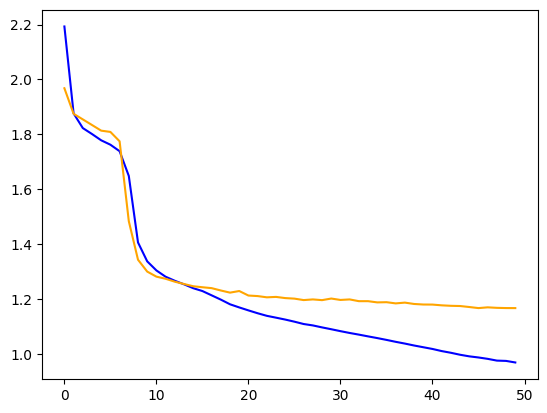

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.619000,2.204980
2,2.145800,2.149602
3,2.092200,2.114626
4,2.062800,2.086388
5,2.033200,2.042804
6,1.991700,1.987093
7,1.833200,1.645865
8,1.563200,1.504737
9,1.487200,1.474157
10,1.446500,1.456925


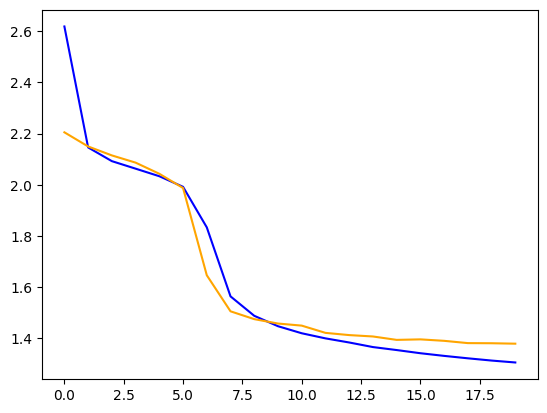

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.450400,2.042358
2,1.952800,1.941891
3,1.883600,1.904657
4,1.856600,1.896903
5,1.831500,1.867175
6,1.816800,1.863630
7,1.794000,1.853480
8,1.777200,1.841145
9,1.763700,1.826057
10,1.739500,1.812988


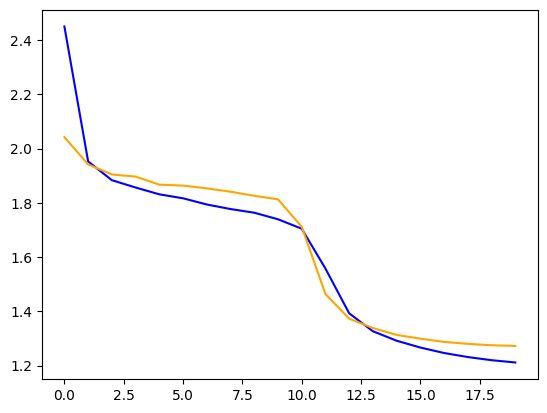

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.580800,2.222810
2,2.150300,2.144727
3,2.092600,2.098059
4,2.058500,2.092640
5,2.033100,2.043252
6,1.997000,1.988631
7,1.844400,1.675358
8,1.615500,1.543470
9,1.539600,1.512260
10,1.511000,1.482347


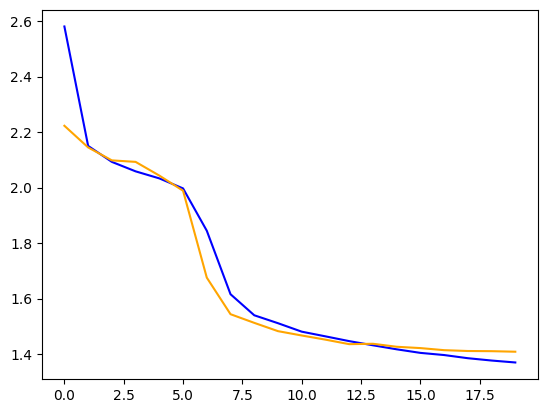

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.472200,2.161263
2,2.109000,2.097143
3,2.062300,2.084442
4,2.028500,2.043432
5,1.994200,1.989386
6,1.865000,1.680884
7,1.619700,1.529785
8,1.526300,1.477756
9,1.483100,1.452512
10,1.455000,1.417369


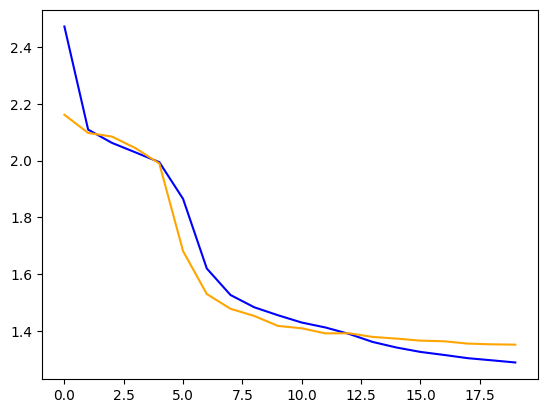

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.535500,2.245211
2,2.153600,2.121165
3,2.085500,2.103555
4,2.053900,2.083397
5,2.023300,2.049366
6,1.998400,2.015285
7,1.936800,1.852524
8,1.680800,1.559243
9,1.549100,1.505725
10,1.499500,1.467723


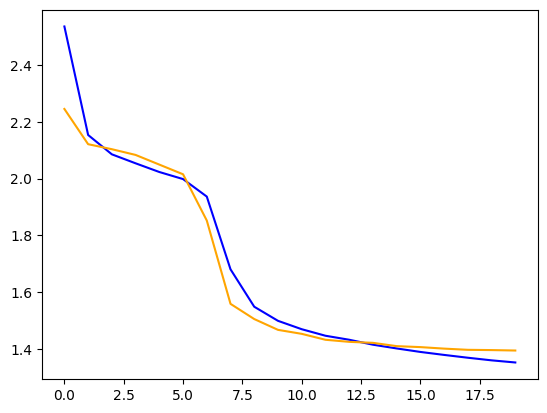

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.164000,1.935570
2,1.857800,1.866910
3,1.820600,1.870092
4,1.802200,1.844536
5,1.780000,1.815805
6,1.758000,1.814837
7,1.739100,1.798230
8,1.708800,1.718688
9,1.554400,1.415589
10,1.377000,1.339127


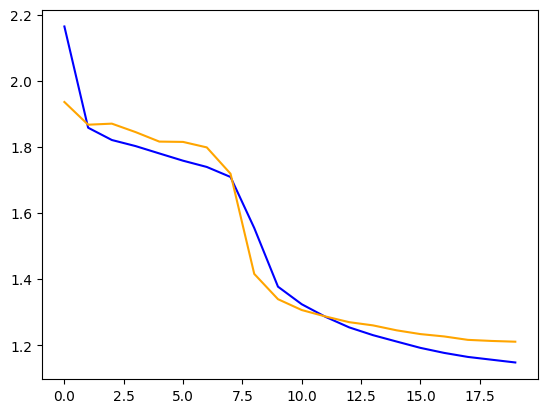

,name,max_length,emb_dim,attention_heads,layers,dropout,learning_rate,epochs,batch_size,ran,runtime,runtime_min,min_loss,at_epoch,perplexity,incorrect_notes,correct_notes,correct_rate
0,a1_50,1024,256,4,6,0,0.001,50,4,yes,646.7671,10.78,1.346300,43.0,679.524536,NaN,NaN,NaN
1,a2_50,1024,256,4,6,0,0.001,50,4,yes,631.2694,10.52,1.177220,46.0,289.333679,NaN,NaN,NaN
2,a3_50,1024,256,4,6,0,0.001,50,4,yes,662.6886,11.04,1.390447,36.0,275.937103,NaN,NaN,NaN
3,b_50,1024,256,4,6,0,0.001,50,4,yes,652.5901,10.88,1.352880,36.0,442.333618,NaN,NaN,NaN
4,c_50,1024,256,4,6,0,0.001,50,4,yes,643.5783,10.73,1.369530,36.0,364.786407,NaN,NaN,NaN
5,d_50,1024,256,4,6,0,0.001,50,4,yes,634.2541,10.57,1.167735,50.0,486.180145,NaN,NaN,NaN
6,a1,1024,256,4,6,0,0.001,20,4,yes,253.2759,4.22,1.378125,20.0,94.867638,NaN,NaN,NaN
7,a2,1024,256,4,6,0,0.001,20,4,yes,262.6371,4.38,1.272294,20.0,103.435127,NaN,NaN,NaN
8,a3,1024,256,4,6,0,0.001,20,4,yes,263.4213,4.39,1.408199,20.0,202.802673,NaN,NaN,NaN
9,b,1024,256,4,6,0,0.001,20,4,yes,263.1353,4.39,1.351377,20.0,88.056297,NaN,NaN,NaN


In [4]:
rows = []

for index, row in model_df.iterrows():
    
    # only run models that not ran yet
    if row["ran"] == "yes":
        continue
    
    # create model name directories
    model_name = row["name"]
    model_vocab = model_name.split("_")[0]
    model_dirs = {
        "loss": f"{PATH_MODELS_LOSS}/{model_name}",
        "out": f"{PATH_MODELS_CONFIG}/{model_name}"
    }
    for key in model_dirs:
        if not os.path.exists(model_dirs[key]):
            os.makedirs(model_dirs[key])
    
    # save hyperparameters as dictionary
    model_hyperparameters = {
        "max_length": row["max_length"],
        "emb_dim": row["emb_dim"],
        "attention_heads": row["attention_heads"],
        "layers": row["layers"],
        "dropout": row["dropout"],
        "learning_rate": row["learning_rate"],
        "epochs": row["epochs"],
        "batch_size": row["batch_size"],
    }
    
    # create tokenizer
    tokenizer = GPT2Tokenizer(
        vocab_file=f"{PATH_VOCAB}/vocab_{model_vocab}.json", 
        merges_file=f"{PATH_VOCAB}/merges.txt")
    tokenizer.add_special_tokens({'pad_token': 'PAD', 'bos_token': 'BOS', 'eos_token': 'EOS',})
    
    # read in data
    with open(f"{PATH_WORD_DATA}/{model_vocab}_data.json", 'r') as fp:
        json_data = json.load(fp)
    song_list = []
    for song in json_data:
        song_list.append(json_data[song])
    data = [" ".join(song) for song in song_list]
    split_train_test = int(0.9*len(data))
    
    # create datasets and define data collator
    train_dataset = PaddedDataset(tokenizer=tokenizer, data=data[:split_train_test], max_length=row["max_length"])
    eval_dataset = PaddedDataset(tokenizer=tokenizer, data=data[split_train_test:], max_length=row["max_length"])
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    model_data = {
        "train_dataset": train_dataset,
        "eval_dataset": eval_dataset,
        "data_collator": data_collator,
    }
    
    # create and train model trainer
    trainer = trainer_gpt2_transformer(
        hyperparameters = model_hyperparameters,
        tokenizer = tokenizer,
        data = model_data,
        dirs = model_dirs,
    )
    trainer.train()
    
    # compute perplexity
    inputs = tokenizer.encode("Bar_None".split(" "), return_tensors="pt")
    outputs = trainer.predict(tokenizer.encode("Bar_None".split(" "), return_tensors="pt"))
    logits = outputs.predictions
    probabilities = torch.softmax(torch.from_numpy(logits), dim=-1)
    log_probabilities = torch.log(probabilities)
    num_samples = log_probabilities.size(1)
    total_log_prob = torch.sum(log_probabilities[0, torch.arange(num_samples), inputs[0]])
    perplexity = torch.exp(-total_log_prob / num_samples).item()
    
    # save runtime and model loss
    log_hist = trainer.state.log_history
    eval_loss = [log_hist[i]["eval_loss"] for i in range(1,len(log_hist),2)]
    train_loss = [log_hist[i]["loss"] for i in range(0,len(log_hist)-1,2)]
    runtime = log_hist[-1]["train_runtime"]
    
    model_df.at[index,"perplexity"] = perplexity
    model_df.at[index,"runtime"] = runtime
    model_df.at[index,"runtime_min"] = (runtime/60).__round__(2)
    model_df.at[index,"min_loss"] = min(eval_loss)
    model_df.at[index,"at_epoch"] = np.argmin(eval_loss) + 1

    # show loss plot
    plt.plot(train_loss, color="blue")
    plt.plot(eval_loss, color="orange")
    plt.savefig(f"{model_dirs['loss']}/loss_graph_{model_name}.jpg")
    plt.show()
    
    # save model and set ran to yes
    trainer.save_model(f"{model_dirs['out']}/end_version")
    model_df.at[index,"ran"] = "yes"
    
model_df

In [5]:
model_df.to_excel(f"{PATH_MODELS}/comparison_model_stats.xlsx")